# Breast cancer dataset for binary classification

We will consider the UCI ML Breast Cancer Wisconsin dataset
https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer

We have 569 samples: 212 malignant cases + 357 benign cases.
Let's import the set and get some information about it.

**Goal**: Train the network to diagnose malignant and benign cases based on the given features.


In [1]:
import torch
from torch import nn
import sklearn.datasets
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cpu


## 1. Import data

In [2]:
dataset = sklearn.datasets.load_breast_cancer()
feature_names, target_names = dataset.feature_names, dataset.target_names
print(f"Number of features: {len(feature_names)}")
print(f"Feature names:\n{feature_names}")
print(f"Number of targets: {len(target_names)}")
print(f"Target names: {target_names}")

Number of features: 30
Feature names:
['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
Number of targets: 2
Target names: ['malignant' 'benign']


In [3]:
# Get data
X, y = dataset.data, dataset.target
print(f"Shape of feature set: {X.shape}\nShape of labels set: {y.shape}")

Shape of feature set: (569, 30)
Shape of labels set: (569,)


In [4]:
# Let's see how an example feature looks like
print(f"Example feature:\n{X[42]}\nExample label: {y[42]}")
print(f"Datatype of the feature: {X[42].dtype} | Label: {y[42].dtype}")

Example feature:
[1.907e+01 2.481e+01 1.283e+02 1.104e+03 9.081e-02 2.190e-01 2.107e-01
 9.961e-02 2.310e-01 6.343e-02 9.811e-01 1.666e+00 8.830e+00 1.049e+02
 6.548e-03 1.006e-01 9.723e-02 2.638e-02 5.333e-02 7.646e-03 2.409e+01
 3.317e+01 1.774e+02 1.651e+03 1.247e-01 7.444e-01 7.242e-01 2.493e-01
 4.670e-01 1.038e-01]
Example label: 0
Datatype of the feature: float64 | Label: int64


Let's convert it to `torch.Tensor`, convert it to float32 type (default for PyTorch).

In [5]:
if X.dtype != "torch.float32":
  X = torch.tensor(X, dtype = torch.float )
if y.dtype != 'torch.float32':
  y = torch.tensor(y, dtype = torch.float)


print(f"Datatype: X - {X.dtype}, y - {y.dtype}")

Datatype: X - torch.float32, y - torch.float32


### 1.1. Divide data into training and testing sets


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(f"Shape of training feature tensor: {X_train.shape} | label tensor: {y_train.shape}")
print(f"Shape of testing feature tensor: {X_test.shape} | label tensor: {y_test.shape}")

Shape of training feature tensor: torch.Size([455, 30]) | label tensor: torch.Size([455])
Shape of testing feature tensor: torch.Size([114, 30]) | label tensor: torch.Size([114])


## 2. Construct a simple model.

* Linear layer | 30 -> 1
* Sigmoid activation is included in `nn.BCEWithLogitsLoss()`

In [15]:
model_0 = nn.Linear(in_features = 30, out_features = 1)

In [16]:
# Dummy forward pass
model_0(X_train[37])

tensor([-31.5214], grad_fn=<ViewBackward0>)

### 2.1. Select the loss function and optimizer

In [17]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.01)

## 3. Train the model

  0%|          | 0/500 [00:00<?, ?it/s]

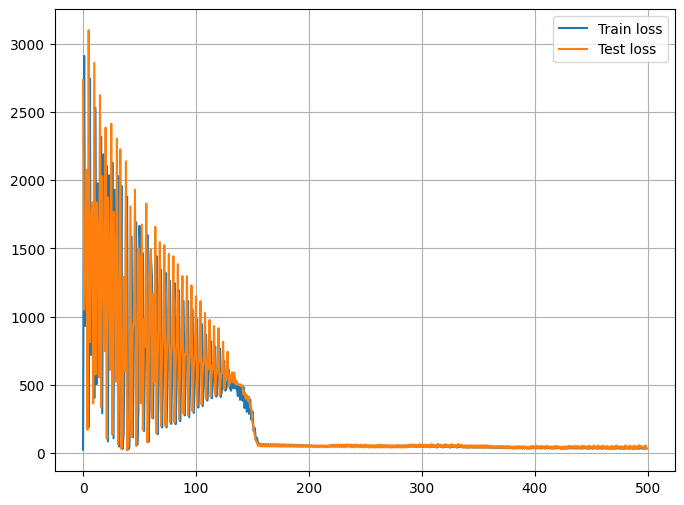

In [18]:
# Setup lists keeping track of the loss
train_loss_list0, test_loss_list0 = [], []

# Set number of epochs
NUM_EPOCHS = 500

# Training loop
for epoch in tqdm(range(NUM_EPOCHS)):
  ### Training
  # Put model in training mode
  model_0.train()

  # Forward pass
  y_logits = model_0(X_train).squeeze()

  # Calculate the loss
  loss = loss_fn(y_logits, y_train)
  train_loss_list0.append(loss.item())

  # Zero gradients
  optimizer.zero_grad()

  # Backpropagation
  loss.backward()

  # Optimizer step
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # Forward pass
    y_test_logits = model_0(X_test).squeeze()

    # Calculate the loss
    test_loss = loss_fn(y_test_logits, y_test)
    test_loss_list0.append( test_loss.item() )

plt.figure(figsize=(8,6))
plt.plot( range(NUM_EPOCHS), train_loss_list0, label="Train loss" )
plt.plot( range(NUM_EPOCHS), test_loss_list0, label="Test loss" )
plt.grid()
plt.legend()

## 4. Get the predictions made on testing data

In [21]:
random_indexes = random.sample( range(len(y_test)), k=5 )
for idx in random_indexes:
  with torch.inference_mode():
    prediction_idx = torch.round( torch.sigmoid( model_0(X_test[idx]) ) ).int()

  prediction_str = target_names[ prediction_idx ]

  true_prediction = target_names[ y_test[idx].int() ]
  print(f"------------")
  print(f"True diagnosis: {true_prediction}")
  print(f"  AI diagnosis: {prediction_str}")


------------
True diagnosis: benign
  AI diagnosis: benign
------------
True diagnosis: malignant
  AI diagnosis: malignant
------------
True diagnosis: malignant
  AI diagnosis: malignant
------------
True diagnosis: benign
  AI diagnosis: benign
------------
True diagnosis: benign
  AI diagnosis: benign


In [23]:
weights = list(model_0.parameters())
numpy_abs_weights = np.abs( weights[0][0].detach().numpy() )

weight_check_list = []
# Create list with tuples of ("feature", numpy_abs_weights)
for i in range(len(numpy_abs_weights)):
  weight_check_list.append( (feature_names[i], numpy_abs_weights[i]) )

sorted_features = sorted(weight_check_list,
                         key=lambda weight: weight[1],
                         reverse = True)

print("Most impactful features in diagnosis according")
print("to the trained neural network:")
sorted_features

Most impactful features in diagnosis according
to the trained neural network:


[('worst perimeter', 13.775981),
 ('mean perimeter', 13.479534),
 ('worst area', 8.608936),
 ('mean area', 6.942045),
 ('area error', 5.519744),
 ('worst texture', 4.999988),
 ('mean texture', 4.0066495),
 ('worst radius', 2.2721646),
 ('mean radius', 2.249187),
 ('worst concave points', 0.18645081),
 ('worst symmetry', 0.18397608),
 ('symmetry error', 0.17596203),
 ('mean smoothness', 0.16297022),
 ('texture error', 0.16166995),
 ('mean fractal dimension', 0.1498344),
 ('mean compactness', 0.14517987),
 ('worst fractal dimension', 0.13899654),
 ('worst compactness', 0.1352563),
 ('perimeter error', 0.13321872),
 ('concave points error', 0.12259657),
 ('fractal dimension error', 0.11394837),
 ('compactness error', 0.11156193),
 ('worst smoothness', 0.077313565),
 ('concavity error', 0.07730091),
 ('radius error', 0.06794576),
 ('smoothness error', 0.058466006),
 ('mean concavity', 0.047797117),
 ('worst concavity', 0.032289065),
 ('mean symmetry', 0.03136433),
 ('mean concave points', 